<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [499]:
#!pip install imbalanced-learn -q
#!pip install wordcloud
#!pip install swifter - q
#!pip install xgboost
#!pip install urlextract

In [1]:
import pandas as pd
from tqdm import notebook
import re
from time import time 
import torch
import swifter
import transformers
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import numpy as np
from numpy.random import default_rng
import transformers
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report, make_scorer
from __future__ import unicode_literals, print_function
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import FixedThresholdClassifier, TunedThresholdClassifierCV
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
from urlextract import URLExtract

In [3]:
#from wordcloud import WordCloud

In [4]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
pd.set_option('display.max_colwidth', None)

In [6]:
RANDOM_STATE = 88

## Подготовка

In [7]:
url = 'https://code.s3.yandex.net/datasets/toxic_comments.csv'

In [8]:
df = pd.read_csv(url)

In [9]:
df.head()

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [11]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [12]:
df['text'].duplicated().sum()

0

In [13]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [15]:
def w_count(dataframe, df_cleaning=False, stop_words_filtered = False):

    if df_cleaning == True:
        dataframe = dataframe.str.lower()
        display('text lowered')
        dataframe = dataframe.swifter.apply(lambda x: re.sub(r'\W', ' ', x))
        display('only words in text ')
        dataframe = dataframe.swifter.apply(lambda x: re.sub(r'\s+', ' ', x))
        display('text is striped')
        
    
    word2count = {}
    
    for data in dataframe:
        words = nltk.word_tokenize(data)
        for word in words:
            if word not in word2count:
                word2count[word] = 1
            else:
                word2count[word] += 1

    if stop_words_filtered == True:
        display('stop words are removed')
        stop_words = set(stopwords.words('english'))
        filtered_word2count = {word: count for word, count in word2count.items() if word not in stop_words}
        word_freq_df = pd.DataFrame(list(filtered_word2count.items()), columns=['Word', 'Frequency'])
        word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)
    else:
        filtered_word2count = {word: count for word, count in word2count.items()}
        word_freq_df = pd.DataFrame(list(filtered_word2count.items()), columns=['Word', 'Frequency'])
        word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False)

    return word_freq_df

In [16]:
######################################################################################

In [17]:
df['len'] = df['text'].swifter.apply(lambda x: len(x))

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

In [18]:
#df[df['len']>2500]['text'].sample()

In [19]:
#print(' '.join([clean_text(i) for i in nl_split(df['text'][3536])]))

In [20]:
#print(clean_text(df['text'][4581]))

In [21]:
#nl_split(df['text'][152428])

In [22]:
#nl_split(df['text'][4581])

In [23]:
def url_rem(string_):
    extractor = URLExtract()
    urls = extractor.find_urls(string_)
    for url in urls:
        string_ = re.sub(re.escape(url), ' XXLINK ', string_)
    
    string_ = re.sub(r'https?://\S+|www\.\S+', ' XXLINK ', string_)
    string_ = re.sub(r'<.*?>+', ' XXLINK ', string_)
    return string_

In [24]:
#url_rem('(taken from: http://ec.europa.eu/justice_home/news/events/events_2008_en.html) \n\nEuropean')

In [25]:
df['text'][149325][60:70]

'tp://ec.eu'

In [26]:
def mail_user_rem(string_):
    
    string_ = re.sub(r'[A-Za-z0-9\_]*@[A-Za-z]*\.?[A-Za-z0-9]*', ' XXMAIL ', string_)
    string_ = re.sub(r'User:\S+', ' XXUSER ', string_)

    return string_

In [27]:
def nl_split(string):
    
    string = re.split('\n+',string)
    result = [sent_tokenize(i.strip()) for i in string]
    result = sum(result, [])
    
    return [i for i in result if len(i)>1]

In [28]:
def clean_text(string):
    
    string = re.sub(r'\[{1,}.+\]{1,}', ' XXRBRCT ', string)
    string = re.sub(r'\{{1,}.+\}{1,}', ' XXRBRCT ', string)
    string = re.sub(r'File:.+\S+|Image:.+\S+', ' XXFILE ', string)
    string = re.sub(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', ' XXIP ',string) 
    
    string = re.sub(r'(\W)\1+|(\D)\1+', r'\1', string)
    string = re.sub(r'[\_\+]', ' ', string)
    string = re.sub("['”‘’“]", r'"', string)
    string = re.sub("[A-Za-z]+", lambda ele: " " + ele[0] + " ", string)
    string = re.sub(r'\s+', ' ', string)
    
    return string.strip()

In [29]:
def clean_sents(string):
    string = url_rem(string)
    sents = nl_split(string)
    cl_sents = [url_rem(sent) for sent in sents]
    cl_sents = [mail_user_rem(sent) for sent in cl_sents]
    #string = mail_user_rem(string)
    #sents = nl_split(string)
    cl_sents = [clean_text(sent) for sent in cl_sents]

    
    
    return cl_sents

In [30]:
#clean_sents(df['text'][10])

In [523]:
url_rem(df['text'][149325])

'"\nPlease read and notice the word jointly. \n\n(taken from:  xxlink \n\nEuropean Hearing: ""Crimes Committed by Totalitarian Regimes""\nOn 8 April 2008 a European Hearing entitled ""crimes committed by totalitarian regimes"" took place in Brussels. This was organised jointly by the Slovenian Presidency of the European Union and the European Commission around the two key issues of recognition of the crimes and reconciliation.   "'

In [524]:
[url_rem(sen) for sen in nl_split(df['text'][149325])]

['Please read and notice the word jointly.',
 '(taken from:  xxlink ',
 'European Hearing: ""Crimes Committed by Totalitarian Regimes""',
 'On 8 April 2008 a European Hearing entitled ""crimes committed by totalitarian regimes"" took place in Brussels.',
 'This was organised jointly by the Slovenian Presidency of the European Union and the European Commission around the two key issues of recognition of the crimes and reconciliation.   "']

In [592]:
clean_sents(df['text'][149325])

['Please read and notice the word jointly .',
 '( taken from : XXLINK',
 'European Hearing : " Crimes Committed by Totalitarian Regimes "',
 'On 8 April 2008 a European Hearing entitled " crimes committed by totalitarian regimes " took place in Brussels .',
 'This was organised jointly by the Slovenian Presidency of the European Union and the European Commission around the two key issues of recognition of the crimes and reconciliation . "']

In [643]:
#clean_sents(df['text'][80726])

In [31]:
def chunker(string):

    sents_ = clean_sents(string)

    tokenized_sents = [tokenizer.encode(sent, add_special_tokens=True) for sent in sents_]

    #for sent in tokenized_sents:
    #    if sent not in usents:# and sent!=[101,1012,102] and sent!=[101,102]:
    #        usents.append(sent)

    if len(tokenized_sents)>1:
        result = sum(tokenized_sents,[])
    else:
        result = tokenized_sents[0]
    
        
    if len(result)>512:

        result = result[:129] + result[-382:]+[102]
        
    
    return result

In [522]:
#df['text'][80726]

In [531]:
df_toxic = df[df['toxic']==1]#['text']

In [532]:
df_non_toxic = df[df['toxic']==0]#['text']

In [533]:
words_w_trash = w_count(
    df['text'],
    df_cleaning=False)

In [534]:
words_w_trash0 = w_count(
    df_non_toxic['text'],
    df_cleaning=False)

In [535]:
words_w_trash1 = w_count(
    df_toxic['text'],
    df_cleaning=False)

In [21]:
words_wo_trash = w_count(
    df['text'],
    df_cleaning=True)

'text lowered'

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

'text is striped'

In [22]:
words_wo_trash0 = w_count(
    df_non_toxic['text'],
    df_cleaning=True)

'text lowered'

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'text is striped'

In [23]:
words_wo_trash1 = w_count(
    df_toxic['text'],
    df_cleaning=True)

'text lowered'

Pandas Apply:   0%|          | 0/16186 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/16186 [00:00<?, ?it/s]

'text is striped'

In [24]:
words_wo = w_count(
    df['text'],
    df_cleaning=True,
    stop_words_filtered=True)

'text lowered'

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

'text is striped'

'stop words are removed'

In [25]:
words_wo0 = w_count(
    df_non_toxic['text'],
    df_cleaning=True,
    stop_words_filtered = True)

'text lowered'

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'text is striped'

'stop words are removed'

In [26]:
words_wo1 = w_count(
    df_non_toxic['text'],
    df_cleaning=True,
    stop_words_filtered=True)

'text lowered'

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'only words in text '

Pandas Apply:   0%|          | 0/143106 [00:00<?, ?it/s]

'text is striped'

'stop words are removed'

In [536]:
def bars(df_list):
    
    fig, ax = plt.subplots(1,3,figsize=(12,8))
    
    ax[0].barh(df_list[0]['Word'],df_list[0]['Frequency'])
    ax[1].barh(df_list[1]['Word'],df_list[1]['Frequency'])
    ax[2].barh(df_list[2]['Word'],df_list[2]['Frequency'])

    

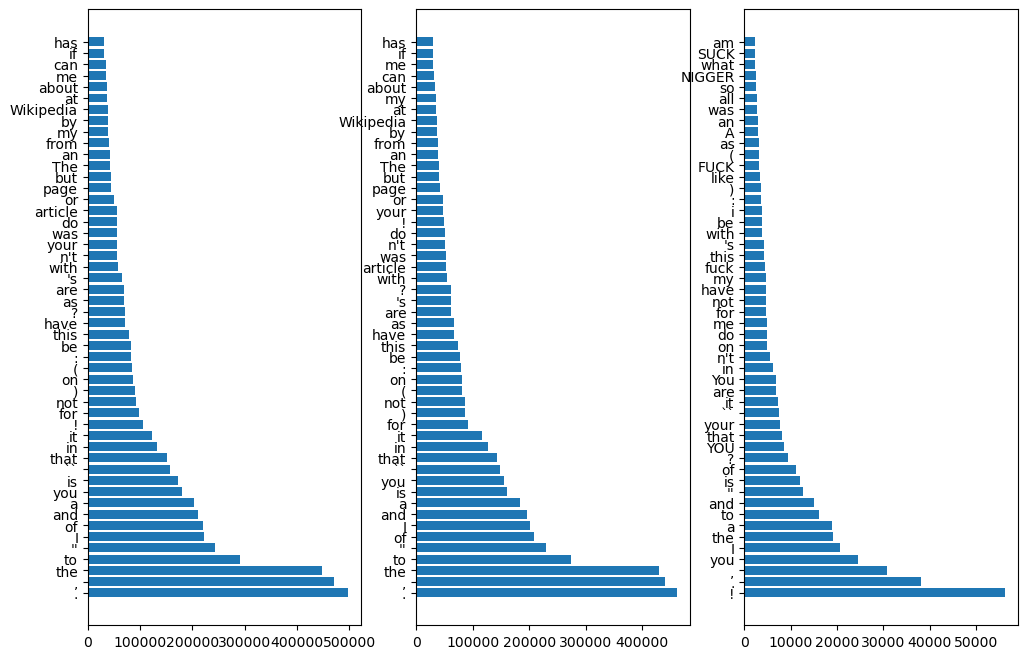

In [537]:
bars([words_w_trash.head(50),words_w_trash0.head(50),words_w_trash1.head(50)])

In [135]:
#bars([words_wo_trash.head(50),words_wo_trash0.head(50),words_wo_trash1.head(50)])

In [136]:
#bars([words_wo.head(50),words_wo0.head(50),words_wo1.head(50)])

for item in [words_wo_trash,words_wo_trash0,words_wo_trash1]:
    display(item[item['Frequency']>1].tail(50))

for item in [words_w_trash,words_w_trash0,words_w_trash1]:
    display(item[item['Frequency']>1].tail(50))

In [538]:
words_w_trash.tail(50)#,words_w_trash0.head(50),words_w_trash1.head(50)])

,Word,Frequency
155878,Thai-Vietnamese,1
155881,post-World-War,1
155918,catacombs,1
155919,'multicultural,1
155920,'celebrating,1
155974,terminalogy,1
155957,unf,1
155959,SPOUTED,1
155960,INTENTIONALLY,1
155961,bunchofgrapes,1


In [539]:
words_w_trash0.tail(50)

,Word,Frequency
146582,soul-damning,1
146583,nation-destroying,1
146586,majoritarian,1
146590,dooms,1
146591,damns,1
146625,==Superscript,1
146627,rDNS,1
146628,RFC1912,1
146686,Fieryangel,1
146675,noze,1


In [649]:
words_w_trash1.iloc[-1050:-1000]

,Word,Frequency
29670,DUMMASSES,1
29650,salves,1
29669,STORIES,1
29668,dummasses,1
29666,nanking,1
29664,admiral,1
29663,CONVENIENT,1
29661,HAVOC,1
29658,textBLOCK,1
29657,sadist,1


In [622]:
df['text'][28491]

"Heraldic translation: help needed \nPlease can you translate a blazon. I drew the coat of arms of Coubron but I don't know how to describe in English the hunting horn on which some elements are of an other colour: the little pipe in which you blow, the lace and the metal ring at the end of the horn. Can you help me, please?"

In [640]:
tokenizer.decode(chunker(df['text'][57666]))

'[CLS] guessing you " ve heard it. [SEP] [CLS] so i wanna know if you want some birthday - cake - cake - cake - cake - cake - cake - birthday - cake - cake - cake - cake!? [SEP] [CLS] because imma make you my bitch tonight ; ) hehe ( in all honesty, that song is beyond ridik ) • talk 2 me " [SEP]'

In [638]:
df[df['text'].str.contains('Birthday-cake-cake-cake')]

,text,toxic
57666,"""\n\n Guessing you've heard it.... \n\nSo I wanna know if you want some Birthday-cake-cake-cake-cake-cake-cake-Birthday-cake-cake-cake-cake!? Because Imma make you my bitch tonight ;) Hehe (in all honesty, that song is beyond ridik) • Talk2Me """,1


In [34]:
df['word_count'] = df['text'].swifter.apply(lambda x: len(word_tokenize(x)))

Pandas Apply:   0%|          | 0/159292 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
df['sent_count'] = df['text'].swifter.apply(lambda x: len(sent_tokenize(x)))

In [ ]:
df['len'] = df['text'].swifter.apply(lambda x: len(x))

In [ ]:
df[df['toxic']==1]['word_count'].hist(bins=150)

In [ ]:
df[df['toxic']==0]['word_count'].hist(bins=150)

In [ ]:
df[df['toxic']==1]['sent_count'].hist(bins=150)

In [ ]:
df[df['toxic']==0]['sent_count'].hist(bins=150)

In [ ]:
df[df['toxic']==1]['len'].hist(bins=150)

In [ ]:
df[df['toxic']==0]['len'].hist(bins=150)

In [ ]:
def distribution_plt(df_list, name, val_list, plt_xlim=1):

    x_max = min([series.max() for series in df_list])* plt_xlim

    fig, ax = plt.subplots(2,1,figsize=(10,8))
    ax[0].boxplot([df for df in df_list], vert=False)

    ax[0].set_yticklabels(val_list)
    ax[0].set_xlabel(name)
    ax[0].set_xlim([0, x_max])

    ax[1].hist([df for df in df_list], histtype='stepfilled', bins=500)
    ax[1].set_ylabel('частота')
    ax[1].set_xlabel(name)
    ax[1].set_xlim([0, x_max])

    
    plt.suptitle(f'Ящики с усами и гистограмма для признака "{name}"')
    plt.legend(val_list);
    #plt.xlim((0,x_max))

In [ ]:
name_dict = {'word_count' : 'количество слов',
 'sent_count' : 'количество предложений',
 'len' : 'количество символов'}

In [ ]:
for col in ['word_count', 'sent_count', 'len']:
    
    distribution_plt(
        
        [df[df['toxic']==1][col], df[df['toxic']==0][col]],
        
        name_dict[col],
        
        ['токсичные\nкомментарии', 'не токсичные\nкомментарии'],
        
        0.1)

In [ ]:
df.info()

In [ ]:
1/0

In [42]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [43]:
tokenizer

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [37]:
tokenizer.added_tokens_encoder

{'[PAD]': 0, '[UNK]': 100, '[CLS]': 101, '[SEP]': 102, '[MASK]': 103}

def clean_text(string):

    string = string.strip()
    #string = re.sub(r'\[?https?://\S+\]?|\[?www\.\S+\]?', ' [lnkt] ', string)

    string = re.sub(r'https?://\S+|www\.\S+', ' lnkt ', string)
    
    string = re.sub(r'\[{1,}.+\]{1,2}', ' brct ', string)
    string = re.sub(r'\{{1,}.+\}{1,}', ' rbrct ', string)
    #string = re.sub('\\d+\\.?', ' dgtl ', string)
    string = re.sub(r'(\W)\1+|(\D)\1+', r'\1', string)
    string = re.sub(r'[\_\+\-]',' ',string)
    
    string = re.sub(r'\s+', ' ', string)
    
    return string.strip()#.lower() #best

def chunker(string):

    sents_ = nl_split(string)

    #tokenized_sents = [tokenizer.encode(clean_text(sent), add_special_tokens=True) for sent in sents_]

    tokenized_sents = [tokenizer.encode(clean_text(sent), add_special_tokens=True) for sent in sents_]

    usents=[]
    usents=tokenized_sents
    
    #for sent in tokenized_sents:
    #    if sent not in usents:# and sent!=[101,1012,102] and sent!=[101,102]:
    #        usents.append(sent)
    
    if len(usents)>1:
       result =  sum(usents, [])
    
    elif len(usents)==1:
        result = usents[0]
    
    else:
        result = tokenizer.encode(sents_[0])

    if len(set(result))/len(string)<0.02:
        result = list(dict.fromkeys(result))
        
    #if len(result)>512:
    #    result = result[:511]+[102]
    #    result = [101] + result[:511]+[102]
        #result = result[:129] + result[-382:]+[102]
        
    
    return [101] + result[:510]+[102]#result

tokenizer.decode(chunker(df['text'][96905]))

tokenizer.decode(chunker(df['text'][4704]))

tokenizer.decode(chunker(df['text'][82496]))

df['first_sent'] = df['text'].swifter.apply(lambda x: nl_split(x)[0])

df['after_tok'] = df['text'].swifter.apply(lambda x: tokenizer.decode(chunker(x)))

df['a_t_len'] = df['after_tok'].apply(lambda x: len(x))

df['after_tok'].duplicated().sum()

orientation_list = ['gay', 'lesb', 'trans', 'lgbt']
relig_list = ['christ', 'islam', 'judai','budd', 'jesus', 'allah', 'yahweh']
family_list = ['mom', 'dad', 'papa', 'daddy', 'son', 'daughter', 'mother', 'child']

df['orient'] =  df['text'].str.contains('|'.join(orientation_list), flags=re.IGNORECASE)
df['relig'] =  df['text'].str.contains('|'.join(relig_list), flags=re.IGNORECASE)
df['family'] =  df['text'].str.contains('|'.join(family_list), flags=re.IGNORECASE)

df.sort_values(by='after_tok').iloc[50:100]

df.drop_duplicates(subset='after_tok', inplace=True)

df.reset_index(drop=True, inplace=True)

In [602]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [46]:
def logy(feats, target):
    lr = LogisticRegression(random_state=RANDOM_STATE,max_iter=100000,class_weight='balanced')
    lr.fit(feats, target)
    scores = cross_val_score(lr, feats, target, cv=5, scoring='f1_macro')
    return scores

In [ ]:
1/0

In [76]:
samp = df.sample(n=64000, random_state=RANDOM_STATE)

In [33]:
9600*2

19200

In [77]:
X_train, X_test, y_train, y_test = train_test_split(
    #samp[['text','orient','relig','family']],
    samp['text'],
    samp['toxic'],
    test_size = 0.5,
    random_state = RANDOM_STATE,
    stratify = samp['toxic'])

In [78]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32000,), (32000,), (32000,), (32000,))

sampler = RandomUnderSampler(random_state=RANDOM_STATE)
X_resample, y_resample = sampler.fit_resample(pd.DataFrame(X_train), pd.DataFrame(y_train)) 

X_resample.shape, y_resample.shape

res_df = X_resample.join(y_resample)

res_samp = res_df.sample(n=25000, random_state=RANDOM_STATE)

test_samp = pd.DataFrame(X_test).join(pd.DataFrame(y_test)).sample(n=res_samp.shape[0], random_state=RANDOM_STATE)

res_samp.shape

test_samp.shape

In [36]:
class BertTokenizer(object):

    def __init__(self, text, batch_size=1):
        
        self.text = text
        self.batch_size = batch_size
        #self.model_class ,self.pretrained_weights = (
        #    transformers.BertModel, 'bert-base-uncased')
        self.model_class ,self.pretrained_weights = (
            transformers.DistilBertModel, 'distilbert-base-uncased')    
        
        self.model = self.model_class.from_pretrained(self.pretrained_weights)

    
    def get(self):
        
        tokenized = self.text.swifter.apply(lambda x: chunker(x))
        
        max_len = 0
        
        for tok in tokenized.values:
            if len(tok) > max_len:
                max_len = len(tok)

        padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
        attention_mask = np.where(padded != 0, 1, 0)
        
        batch_size = self.batch_size
        
        embeddings = []
        
        for i in notebook.tqdm(range(len(padded) // batch_size)):
                batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
                attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
                
                with torch.no_grad():
                    batch_embeddings = self.model(batch, attention_mask=attention_mask_batch)
                
                embeddings.append(batch_embeddings[0][:,0,:].numpy())
    
        features = np.concatenate(embeddings)

        return features

df[df['text'].str.contains('I ass. I ass.')]['text']

tokenizer.decode(chunker(df['text'][4703]))

tokenizer.decode(chunker(df['text'][0]))

tokenizer.decode(chunker('someone needs to remove lott 71. 227. 167. 147'))

In [608]:
BertTokenizer(df['text'][0:2]).get()

Pandas Apply:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

array([[ 0.13032961, -0.01442569,  0.12687014, ...,  0.04617344,
         0.23689808,  0.3022972 ],
       [-0.15800789, -0.11857641,  0.2850746 , ..., -0.04971734,
         0.27890518,  0.43226808]], dtype=float32)

In [ ]:
16000/32

In [114]:
clean_sents(df['text'][5327])

['Don " t vandalize other wikipedians pages .', '2 nd warning .', 'XXLINK']

In [115]:
dembs_train = BertTokenizer(text=X_train, batch_size=32).get()

Pandas Apply:   0%|          | 0/32000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [116]:
logy(dembs_train, y_train.values)

array([0.81184391, 0.79644546, 0.80321823, 0.80566535, 0.80639622])

In [661]:
logy(dembs_train, y_train.values)#.mean()

array([0.8       , 0.77162213, 0.80815348, 0.76272903, 0.76909286])

In [651]:
logy(dembs_train, y_train.values).mean()

0.7854730106376293

In [73]:
logy(dembs_train, y_train.values).mean()

0.8073131369641621

In [117]:
dembs_test = BertTokenizer(text=X_test, batch_size=32).get()

Pandas Apply:   0%|          | 0/32000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
#tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#mod = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')

In [ ]:
###############

In [ ]:
def mean_embs(string, model ):
    sents_ = nl_split(string)

    sents_ = [clean_text(sent) for sent in sents_]
    
    tokens = tokenizer(sents_,max_length=512, padding=True, truncation=True, return_tensors='np')
    #model = transformers.DistilBertModel.from_pretrained('distilbert-base-uncased')
    with torch.no_grad():
        batch_embeddings = model(torch.LongTensor(tokens['input_ids']), attention_mask=torch.LongTensor(tokens['attention_mask']))

    embs = batch_embeddings[0][:,0,:].numpy()
    
    
    return np.mean(embs, axis=0)#.reshape(1,768)

In [ ]:
pd.DataFrame(dembs_train).duplicated().sum()

In [75]:
np.array([0.80239492, 0.7986666 , 0.8033005 , 0.79858842, 0.81225364]).mean()

0.8030408159999999

In [ ]:
#array([0.8919973 , 0.8999975 , 0.90249588, 0.89397286, 0.89449786])

In [ ]:
###dembs_test = BertTokenizer(text=test_samp['text'], batch_size=50).get()
####logy(dembs_train, res_samp['toxic'])

In [ ]:
#dembs_test = BertTokenizer(text=X_test['text'], batch_size=50).get()

In [ ]:
#tr = pd.DataFrame(trial).join(pd.DataFrame(res_samp['toxic'].reset_index(drop=1)))

In [ ]:
#tr.head().iloc[:,-5:]

In [ ]:
#tr.tail().iloc[:,-5:]

In [ ]:
#tr.drop_duplicates(inplace=True)
#tr.reset_index(inplace=True,drop=True)

In [ ]:
#tr.tail().iloc[:,-5:]

from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train 
)

sample_weights

In [37]:
def f1_eval(y_true, y_pred,):

    f1 = f1_score(y_pred, y_true, average=None)[1]
    return f1

In [38]:
def f1_xgb(y_pred, dtrain):
    y_true = dtrain.get_label()
    f1 = f1_score( y_pred,y_true, average=None)[1]

    return 'f1', f1

In [39]:
from sklearn.metrics import make_scorer
my_func = make_scorer(f1_eval, greater_is_better=True)

In [40]:
pipe = Pipeline([('models',[LogisticRegression(random_state=RANDOM_STATE,class_weight='balanced')])])

In [51]:
p_wei = y_train.value_counts()[0]/y_train.value_counts()[1]

In [726]:
param_grid = [

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, class_weight='balanced')],
        'models__solver': ['newton-cg', 'liblinear'],
        #'models__class_weight':,
        #'models__C': [0.5,1,3,5],#,
        #'models__penalty': ['l1', 'l2']
          
    },

    {
        'models': [XGBClassifier(
            random_state=RANDOM_STATE,
            ###objective = 'binary:logistic',
            eval_metric = f1_xgb,
            #maximize=True,
            #eval_metric='logloss',
            #scale_pos_weight = y_train.value_counts(normalize=1)[0]
            scale_pos_weight = p_wei
            
            )],
        'models__n_estimators':[500, 1000, 1250],#[1000, 1250],#, 1500, 2000],#[1000, 1250, 1500, 2000],
        'models__max_depth':[4],#[4,5,6],
        'models__learning_rate':[0.3,0.2, 0.1, 0.4]#[0.1,0.2, 0.25 , 0.3],[0.3,0.4,0.2, 0.1, 0.05]
        #'models__alpha':[0.1, 0.3]#,
        #'models__eval_metric': [f1_xgb]
    }

]

In [138]:
param_grid = [
    {
        'models': [XGBClassifier(
            random_state=RANDOM_STATE,
            ###objective = 'binary:logistic',
            #eval_metric = f1_xgb,
            eval_metric='logloss',
            #maximize=True,
            #eval_metric='logloss',
            #scale_pos_weight = y_train.value_counts(normalize=1)[0]
            scale_pos_weight = p_wei
            
            )],
        'models__n_estimators':[1000, 1250],#, 1500, 2000],#[1000, 1250, 1500, 2000],
        'models__max_depth':[4],#[4,5,6],
        'models__learning_rate':[0.2, 0.1, 0.09,0.07]
    }
]

In [129]:
param_grid = [
    {
        'models': [XGBClassifier(
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            #scale_pos_weight = y_train.value_counts(normalize=1)[0]
            scale_pos_weight = p_wei
            
            )],
        'models__n_estimators':[100,200, 500, 2000],#[1000, 1250, 1500, 2000],
        'models__max_depth':[3,6,9],
        'models__learning_rate':[0.2, 0.1, 0.01],
        #'models__subsample':[0.8, 1],
        #'models__colsample_bytree':[0.8, 1],
        'models__reg_alpha':[0, 0.1,1],
        'models__reg_lambda':[1,1.5,2],        
        
        
    }
]

param_grid = [

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, class_weight='balanced')],
        'models__solver': ['newton-cg', 'liblinear'],
        #'models__class_weight':,
        'models__C': [0.5,1,3,5],
        #'models__penalty': ['l1', 'l2']
          
    }
]

In [139]:
grid_search = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5,
    #scoring='f1',
    scoring=my_func,
    n_jobs=-1
)
grid_search.fit(dembs_train, y_train)
#grid_search.fit(trial, y_train.values)
#grid_search.fit(trial, res_samp['toxic'])
###grid_search.fit(tr.drop('toxic', axis=1), tr['toxic'])

,estimator,Pipeline(step..._state=88)])])
,param_grid,"[{'models': [XGBClassifier...ree=None, ...)], 'models__learning_rate': [0.2, 0.1, ...], 'models__max_depth': [4], 'models__n_estimators': [1000, 1250]}]"
,scoring,make_scorer(f...hod='predict')
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [ ]:
#n_estimators 	2000, learning_rate 	0.1, max_depth 	5

In [140]:
pd.DataFrame(grid_search.cv_results_)[['rank_test_score', 'mean_test_score','params']].sort_values('rank_test_score')

,rank_test_score,mean_test_score,params
7,1,0.726959,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.07, 'models__max_depth': 4, 'models__n_estimators': 1250}"
2,2,0.726844,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.1, 'models__max_depth': 4, 'models__n_estimators': 1000}"
5,3,0.726374,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.09, 'models__max_depth': 4, 'models__n_estimators': 1250}"
0,4,0.724234,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.2, 'models__max_depth': 4, 'models__n_estimators': 1000}"
3,5,0.723999,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.1, 'models__max_depth': 4, 'models__n_estimators': 1250}"
1,6,0.723967,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric='logloss', feature_types=None, feature

In [724]:
pd.DataFrame(grid_search.cv_results_)[['rank_test_score', 'mean_test_score','params']].sort_values('rank_test_score')

,rank_test_score,mean_test_score,params
4,1,0.700978,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=<function f1_xgb at 0x000002D80FAFBA60>, feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.3, 'models__max_depth': 4, 'models__n_estimators': 1000}"
5,2,0.700601,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=<function f1_xgb at 0x000002D80FAFBA60>, feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.3, 'models__max_depth': 4, 'models__n_estimators': 1250}"
0,3,0.698003,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=<function f1_xgb at 0x000002D80FAFBA60>, feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.2, 'models__max_depth': 4, 'models__n_estimators': 1000}"
1,4,0.696491,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=<function f1_xgb at 0x000002D80FAFBA60>, feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.2, 'models__max_depth': 4, 'models__n_estimators': 1250}"
2,5,0.694416,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None, device=None, early_stopping_rounds=None, enable_categorical=False, eval_metric=<function f1_xgb at 0x000002D80FAFBA60>, feature_types=None, feature_weights=None, gamma=None, grow_policy=None, importance_type=None, interaction_constraints=None, learning_rate=None, max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None, max_depth=None, max_leaves=None, min_child_weight=None, missing=nan, monotone_constraints=None, multi_strategy=None, n_estimators=None, n_jobs=None, num_parallel_tree=None, ...), 'models__learning_rate': 0.1, 'models__max_depth': 4, 'models__n_estimators': 1000}"
3,6,0.692914,"{'models': XGBClassifier(base_score=None, booster=None, callbacks=None, colsample_bylevel=None, colsample_bynod

In [705]:
pd.DataFrame(grid_search.cv_results_)[['rank_test_score', 'mean_test_score','params']].sort_values('rank_test_score').iloc[2]['params']#.head(16)

{'models': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False,
               eval_metric=<function f1_xgb at 0x000002D80FAFBA60>,
               feature_types=None, feature_weights=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, ...),
 'models__learning_rate': 0.1,
 'models__max_depth': 4,
 'models__n_estimators': 1250}

In [706]:
#grid_pred = grid_search.best_estimator_.predict(debs_no_dups_test.drop('toxic', axis=1))

In [120]:
#grid_pred = grid_search.best_estimator_.predict(trial_trial)
grid_pred = grid_search.best_estimator_.predict(dembs_test)

In [121]:
f1_score(grid_pred, y_test,average=None)

array([0.9682829 , 0.71439737])

In [122]:
print(classification_report(grid_pred, y_test))
#print(classification_report(grid_pred, test_samp['toxic']))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     28896
           1       0.69      0.74      0.71      3104

    accuracy                           0.94     32000
   macro avg       0.83      0.85      0.84     32000
weighted avg       0.94      0.94      0.94     32000



In [123]:


classifier_tuned_threshold = TunedThresholdClassifierCV(
    grid_search.best_estimator_, scoring=my_func, n_jobs=-1
).fit(dembs_train, y_train)


In [124]:
ctt_pred = classifier_tuned_threshold.predict(dembs_test)

In [127]:
classifier_tuned_threshold.best_threshold_

0.5555585878864804

In [126]:
f1_score(y_test, ctt_pred)

0.7132530120481928

In [128]:
classifier_other_threshold = FixedThresholdClassifier(
    grid_search.best_estimator_, threshold=0.6, response_method="predict_proba"
).fit(dembs_train, y_train)

cot_pred = classifier_other_threshold.predict(dembs_test)

f1_score(y_test, cot_pred)

0.7105263157894737

In [698]:
f1_score(y_test, cot_pred, average=None)

array([0.96813811, 0.71620227])

In [ ]:
classifier_other_threshold = FixedThresholdClassifier(
    grid_search.best_estimator_, threshold=0.6, response_method="predict_proba"
).fit(debs_no_dups.drop('toxic', axis=1), debs_no_dups['toxic'])
f1_score(debs_no_dups_test['toxic'], classifier_other_threshold.predict(debs_no_dups_test.drop('toxic', axis=1)))#,average=None)#82

In [141]:
res =pd.DataFrame({'a':grid_pred, 'b':y_test})

In [145]:
res[(res['a']==1) & (res['b']!=res['a'])]

,a,b
21729,1,0
110498,1,0
67156,1,0
18832,1,0
73524,1,0
...,...,...
98338,1,0
136948,1,0
34011,1,0
116319,1,0


In [152]:
res[(res['a']==1) & (res['b']!=res['a'])].to_excel('wrong.xlsx')

In [ ]:
pd.DataFrame(dembs_train).duplicated().sum()

In [ ]:
f1_score(y_test, classifier_other_threshold.predict(dembs_test))#82

In [ ]:
cl_preds_adj = classifier_tuned.predict(dembs_val)

In [ ]:
f1_score(cl_preds_adj,y_val)

In [ ]:
res =pd.DataFrame({'a':grid_pred, 'b':test_sample['toxic']})

In [ ]:
pd.DataFrame(probs[0])

In [ ]:
y_test.shape

In [ ]:
pd.DataFrame({'proba':list(probs[1])},
              {'predicted':grid_pred})

In [ ]:
probs_res = pd.DataFrame(zip(y_test,probs[1],grid_pred),columns=['toxic', 'proba', 'pred'])

In [ ]:
probs_res[(probs_res['toxic']!=probs_res['pred']&(probs_res['toxic']==1))]['proba']

In [ ]:
X_test.iloc[1961]

In [ ]:
X_train.apply(lambda x: len(x)).hist()

In [ ]:
X_train.shape

In [ ]:
X_resample.shape

In [ ]:
X_train[X_train.apply(lambda x: len(x))>2000]

In [ ]:
res.shape

In [ ]:
df['text'].

In [ ]:
df[(df.index.isin(res[res['a']!=res['b']].index))&(df['toxic']==1)]['text'].apply(lambda x: tokenizer.decode(chunker(x)))#.sample()



#['b'].value_counts()

In [ ]:
tokenizer.decode(chunker(df.loc[128933]['text']))

In [ ]:
df.loc[128933]['text']

## Обучение

In [ ]:
#from phik.report import plot_correlation_matrix
#from phik import phik_matrix

In [ ]:
#df.info()

phik_overview = phik_matrix(df[['toxic','word_count']],verbose=False)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(18, 14)
) 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df['text_lemm'], 
    df['toxic'], 
    random_state=RANDOM_STATE,
    stratify=df['toxic']
)

In [ ]:
sampler = RandomUnderSampler(random_state=RANDOM_STATE)
X_resample, y_resample = sampler.fit_resample(pd.DataFrame(X_train), pd.DataFrame(y_train)) 


In [ ]:
y_resample.value_counts()

In [ ]:
pd.DataFrame(y_test).value_counts()

## Выводы

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны